In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import h5py
from matplotlib import pyplot as plt
import pickle
from processing_helper_functions import final_processing, unstandardize_data, normalize_names
%matplotlib inline
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]

/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


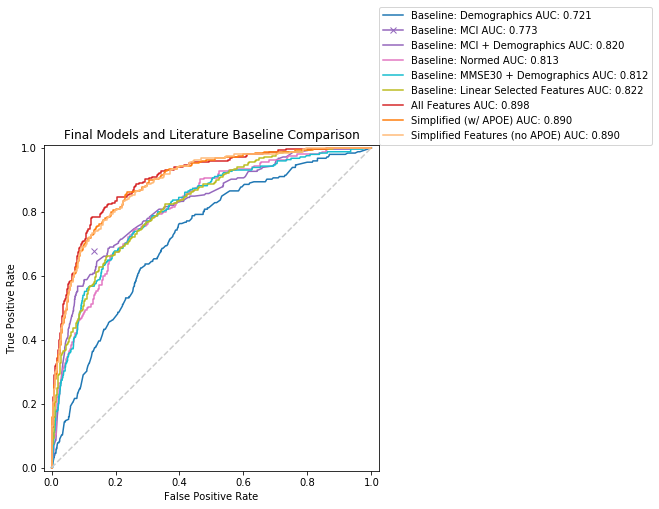

In [3]:
# Final ROC AUC Graph
show_stddev = False
suffix = '2yrprev_within3'
models = ['baseline_demographics_cols', 'baseline_mci_cols', 'baseline_demographics_withmci_cols', 'normed_cog_sum', 
          'baseline_mmse30_cols', 'baseline_linear_selected_features',
          'all_cols', 'simplified_cols_withapoe', 'simplified_cols_withoutapoe']
model_labels = ['Baseline: Demographics', 'Baseline: MCI', 'Baseline: MCI + Demographics', 'Baseline: Normed', 
                'Baseline: MMSE30 + Demographics', 'Baseline: Linear Selected Features',
                'All Features', 'Simplified (w/ APOE)', 'Simplified Features (no APOE)']
colors = [cmaplist[0],cmaplist[8],cmaplist[8],cmaplist[12],cmaplist[-2],cmaplist[-4],cmaplist[6],cmaplist[2],cmaplist[3]]
curves = []

base_fpr = np.linspace(0, 1, 101)
plt.figure(figsize=(6, 6))
for j,model in enumerate(models): 
    if model in ["baseline_linear_selected_features",'normed_cog_sum']:
        file = pickle.load(open('../results/linear_train_%s_2yrprev_within3_singleyear0.p'%(model), 'rb'))
    else:
        file = pickle.load(open('../results/xgb_train_%s_2yrprev_within3_singleyear0.p'%(model), 'rb'))
    model_labels[j] = model_labels[j]+' AUC: '+str('%.3f'%file[1][0])
    fpr = file[5]
    tpr = file[6]
    if model == 'baseline_mci_cols':
        curves += plt.plot(fpr[1], tpr[1], c=colors[j], marker='x')
    else:
        curves += plt.plot(fpr, tpr, c=colors[j])

curves += plt.plot()
    
plt.plot([0, 1], [0, 1],'#cccccc',linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(curves, model_labels,loc=[1,1])
plt.title('Final Models and Literature Baseline Comparison')
#plt.savefig('../images/final_roc_jbhi_revision.pdf')
plt.show()

In [ ]:
for j,model in enumerate(models): 
    if model == "baseline_linear_selected_features":
        file = pickle.load(open('../results/linear_train_%s_2yrprev_within3_singleyear0.p'%(model), 'rb'))
    else:
        file = pickle.load(open('../results/xgb_train_%s_2yrprev_within3_singleyear0.p'%(model), 'rb'))
    model_labels[j] = model_labels[j]+' AUC: '+str('%.3f'%file[1][0])

In [5]:
# load training data matrix

# Which year of past data you would like to train on. One of: 0, 1, 2 where 0 is most recent and 2 is least recent
# If you want to train on more than one year, enter the least recent year to include
years_data = 0
# Set to True if you want to only train on 1 year of data
# Set to False to train on all data through years variable above
only_one = True
# Which time encoding technique should be used
# One of: 'sma', 'ema', 'all_ma', 'all', 'slopes'
encode_method = 'all'
# Which set of features should be used
# One of: 'baseline_demographics_cols', 'baseline_mci_cols', 'baseline_mmse30_cols', 
# 'simplified_cols_withapoe', 'simplified_cols_withoutapoe', 'all_cols'
feature_set = 'all_cols'
# Which downsampling technique should be used
# One of: 'randdownsample', 'matcheddownsample', 'train', 'weighted'
sample_type = "train"

encode_suffix = encode_method
if encode_method in ['all','current']:
    encode_suffix = str(years_data+1)
if encode_method == 'ema':
    encode_suffix = encode_method+str(half_life)
if only_one:
    save_suffix = '%s_%s_2yrprev_within3_singleyear%s'%(sample_type, feature_set, str(int(encode_suffix)-1))
else:
    save_suffix = '%s_%s_2yrprev_within3_yrsincluded%s'%(sample_type, feature_set, encode_suffix)

file_suffix = "2yrprev_within3"
with h5py.File("../DATA/PROCESSED/standardized_stacked_imputed/%s.h5"%file_suffix, 'r') as hf:
    ALL_SAMPLES = hf["samples"][:]
    ALL_FEATURES_TIME = hf["features"][:]
DATA = pd.read_csv("../DATA/PROCESSED/standardized/merged_kept_data_%s.csv"%file_suffix, index_col=0)
ALL_SAMPLES_df = pd.DataFrame(ALL_SAMPLES, columns=["projid","fu_year","onset_label_time","onset_label_time_binary"])
   
constructed_data = final_processing(encode_method, years_data, only_one, feature_set, DATA.columns[6:], ALL_FEATURES_TIME)

train_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/train_%s.txt"%(file_suffix))).values
valid_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/test_%s.txt"%(file_suffix))).values

label_col = np.where(ALL_SAMPLES_df.columns.values=='onset_label_time_binary')[0][0]
label_tr = ALL_SAMPLES[train_idx][:, label_col]
label_val = ALL_SAMPLES[valid_idx][:, label_col] 
data_tr = constructed_data[train_idx]
data_val = constructed_data[valid_idx]

norm_feature_names = normalize_names(data_tr)
xgb_model = pickle.load(open('../results/xgb_%s.dat'%(save_suffix), 'rb'))

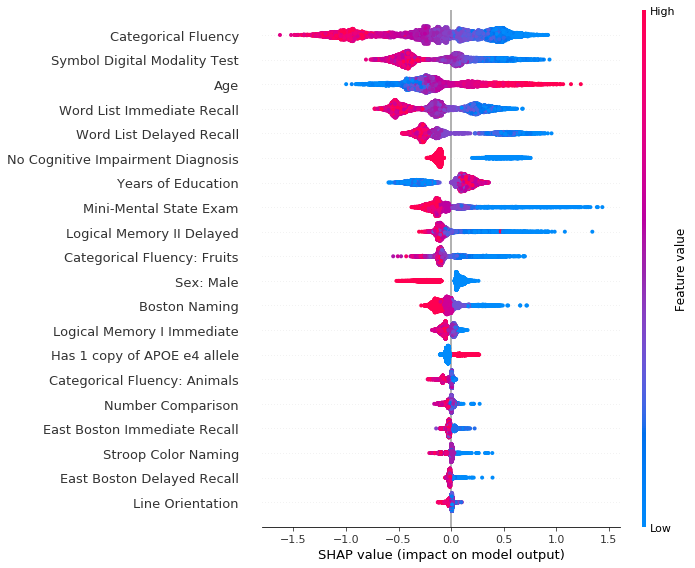

In [6]:
# GBDT SHAP Summary Plot
unnorm_data_tr = unstandardize_data(data_tr)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(data_tr)
shap.summary_plot(shap_values, unnorm_data_tr, feature_names=norm_feature_names, show=False)
plt.savefig('../images/shap.png', dpi=300)

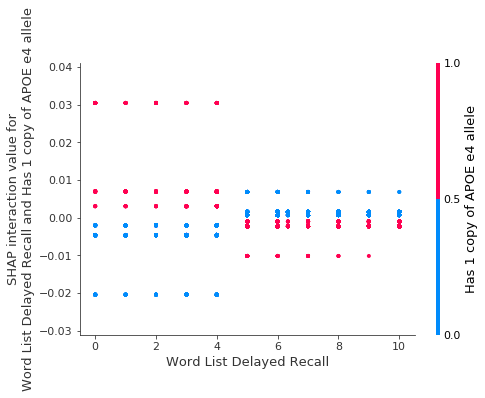

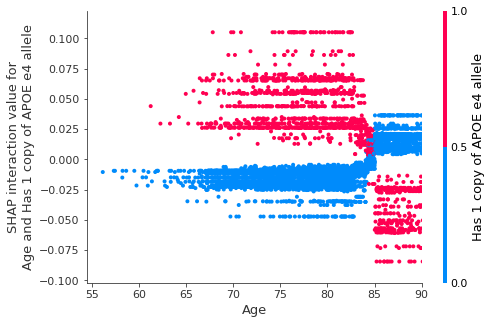

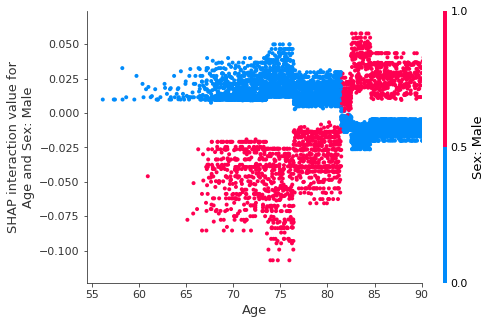

In [7]:
# SHAP Interactions Plots
interaction_values = explainer.shap_interaction_values(data_tr)
shap.dependence_plot(('Word List Delayed Recall','Has 1 copy of APOE e4 allele'), interaction_values, unnorm_data_tr, interaction_index='Has 1 copy of APOE e4 allele', feature_names=norm_feature_names, show=False)
shap.dependence_plot(('Age','Has 1 copy of APOE e4 allele'), interaction_values, unnorm_data_tr, interaction_index='Has 1 copy of APOE e4 allele', feature_names=norm_feature_names, xmax=90, show=False)
shap.dependence_plot(('Age','Sex: Male'), interaction_values, unnorm_data_tr, interaction_index='Gender: Male', feature_names=norm_feature_names, xmax=90, show=False)

Model Prediction: 0.13374609
Model Prediction: 0.27093717
Model Prediction: 0.15862866
Model Prediction: 0.3301436


<Figure size 432x288 with 0 Axes>

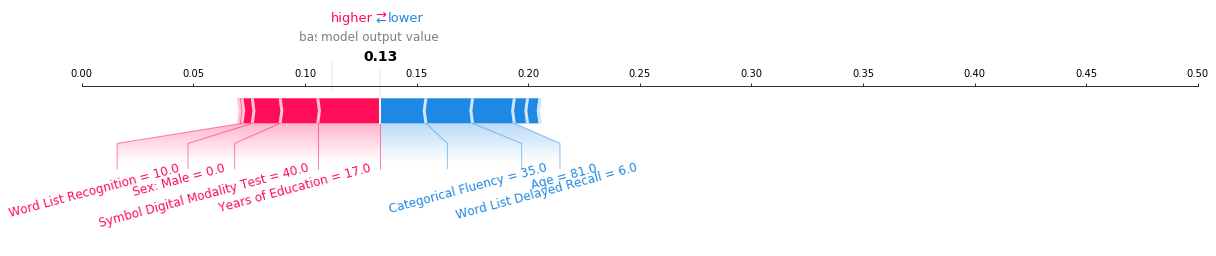

<Figure size 432x288 with 0 Axes>

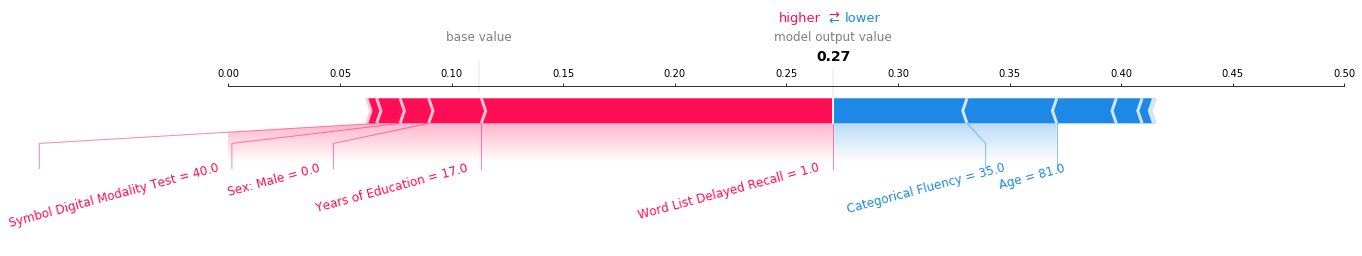

<Figure size 432x288 with 0 Axes>

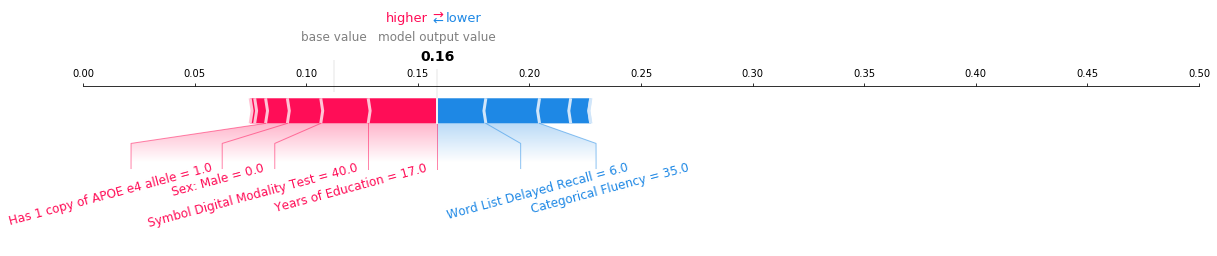

<Figure size 432x288 with 0 Axes>

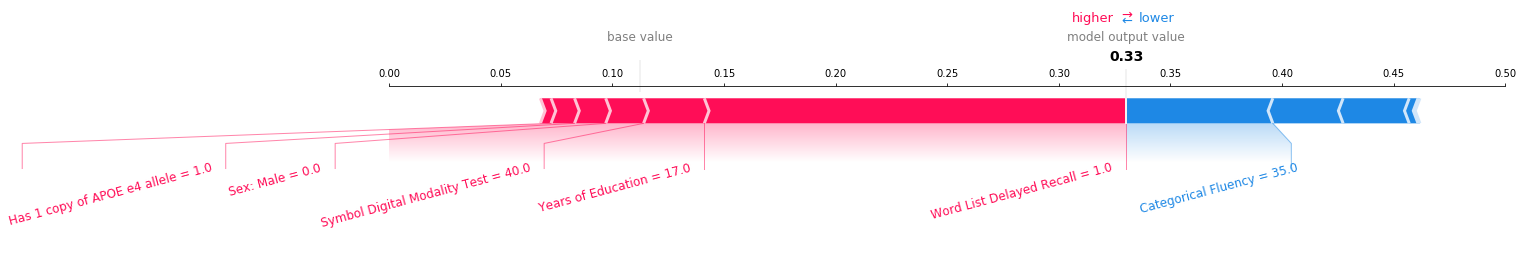

In [9]:
# SHAP Synthetic Individual Explanations Plots
data_val_syn = pd.DataFrame(np.zeros([10,len(data_val.columns)]), columns=data_val.columns)

# controlling cognition scores
for col in data_val_syn.columns:
    if "cts_" in col:
        data_val_syn.loc[0,col] = 0 

data_val_syn.loc[1] = data_val_syn.loc[0].copy()
data_val_syn.loc[1,"cts_wlii"] = -2
        
data_val_syn.loc[2] = data_val_syn.loc[0].copy()
data_val_syn.loc[2,"apoe4_1copy"] = 1

data_val_syn.loc[3] = data_val_syn.loc[0].copy()
data_val_syn.loc[3,"cts_wlii"] = -2
data_val_syn.loc[3,"apoe4_1copy"] = 1

unnorm_data_syn = unstandardize_data(data_val_syn)
syn_unnorm_data_ints = np.around(unnorm_data_syn)
syn_preds = xgb_model.predict(xgb.DMatrix(data_val_syn))

test_explainer = shap.TreeExplainer(xgb_model)
syn_test_shap_values = test_explainer.shap_values(data_val_syn)

for i in range(4):
    print('Model Prediction: '+str(syn_preds[i]))
    plt.figure()
    shap.force_plot(test_explainer.expected_value, syn_test_shap_values[i,:], syn_unnorm_data_ints.iloc[i,:], text_rotation=15, show=False, feature_names=norm_feature_names, matplotlib=True, link="logit")
    plt.xlim(0,0.5)

In [ ]:
# SHAP Real Individual Explanations Plot
sample_number = 0
unnorm_data_val = unstandardize_data(data_val)

test_explainer = shap.TreeExplainer(xgb_model)
test_shap_values = test_explainer.shap_values(data_val)
unnorm_data_ints = np.around(unnorm_data_val)
shap.force_plot(test_explainer.expected_value, test_shap_values[sample_number,:], unnorm_data_ints.iloc[sample_number,:], feature_names=norm_feature_names, text_rotation=10, matplotlib=True)

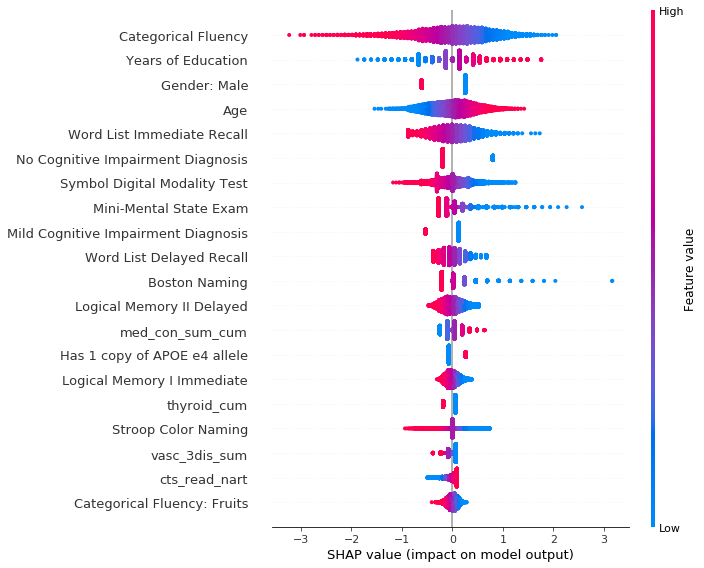

In [7]:
# Linear SHAP Summary Plot
linear_model = pickle.load(open('../results/linear_%s.dat'%(save_suffix), 'rb'))

linear_shap = data_tr.copy()
for x in linear_shap.columns:
    linear_shap[x] = linear_model.coef_[0][list(linear_shap.columns).index(x)]*(linear_shap[x]-linear_shap[x].mean())
linear_shap = linear_shap.values

shap.summary_plot(linear_shap, unnorm_data_tr, feature_names=norm_feature_names, show=False)